# Assignment 9 - Titanic - Machine learning Case study

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Reading Training data

In [2]:
data = pd.read_csv('datasets/titanic/train.csv')

In [3]:
y = data['Survived']
x = data.drop(['Survived', 'Ticket', 'Cabin'], axis = 1)

## Exploratory Data Analysis

In [4]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 62.7+ KB


In [5]:
x.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
x.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

In [7]:
x.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [8]:
x.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [9]:
x[x["Embarked"].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0,NaN
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,NaN


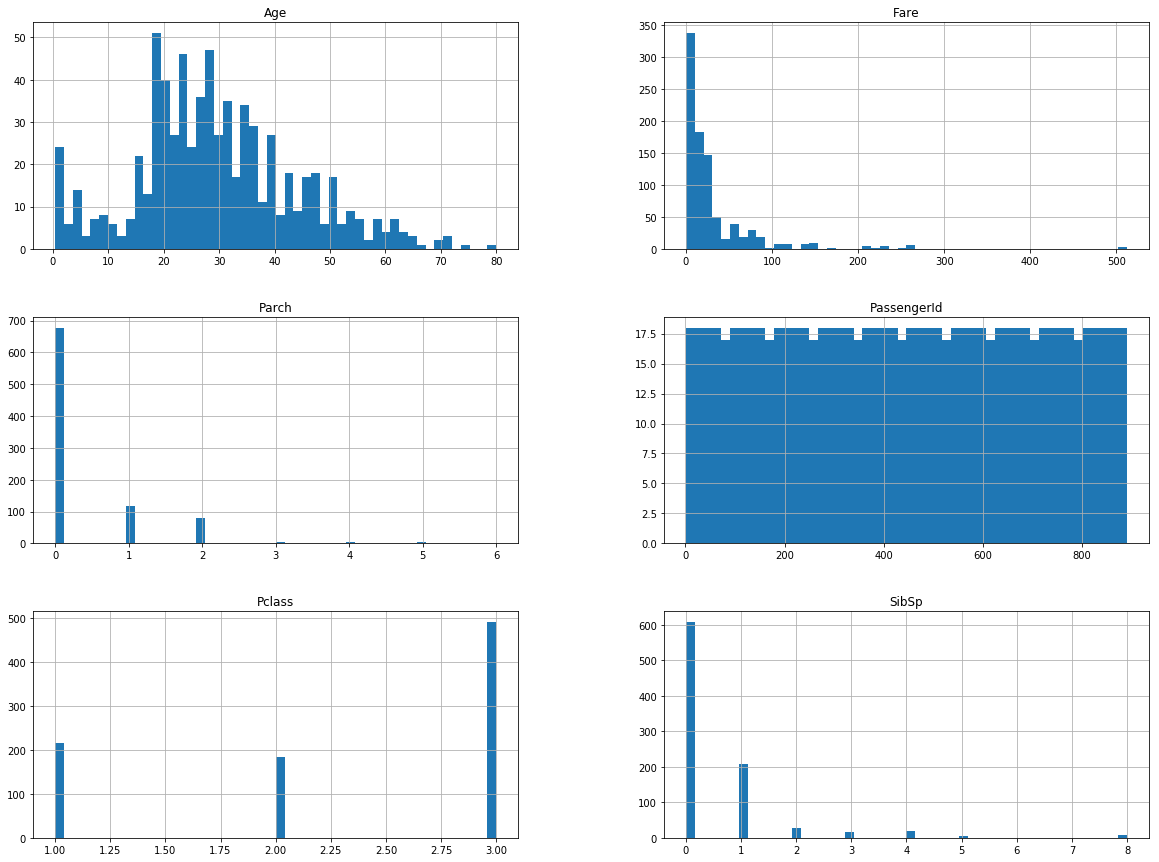

In [10]:
x.hist(bins=50, figsize=(20,15))
plt.show()

## Train Val Data split

In [11]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val = train_test_split(x,y, test_size=0.2, random_state=42)

In [12]:
x_train.shape,y_train.shape,x_val.shape,y_val.shape

((712, 9), (712,), (179, 9), (179,))

In [13]:
num_col = ['PassengerId','Pclass','Age','SibSp','Parch','Fare']
str_col = ['Name','Sex','Embarked']

## Feature Engineering

In [14]:
corr_matrix = data.corr()

In [15]:
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017A3FB2E5C0>,
      dtype=object)

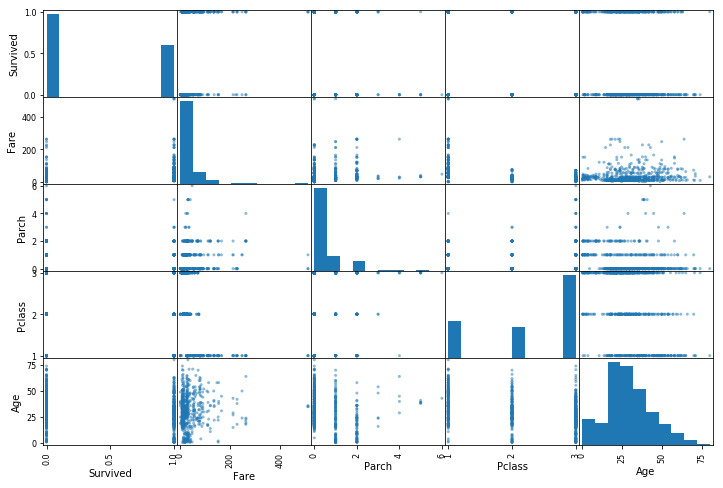

In [16]:
from pandas.plotting import scatter_matrix

# Top three correlated inputs with housing_median_age
attributes = ["Survived", "Fare", "Parch", "Pclass","Age"]
scatter_matrix(data[attributes], figsize=(12, 8))

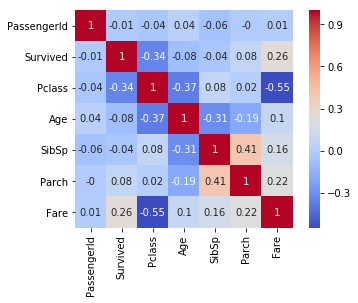

In [17]:
sns.heatmap(np.round(corr_matrix,2),square=True,annot=True,cmap='coolwarm')

### Numerical Features

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, x_in, y=None):
        return self
    def transform(self, x_in):
        return x_in[self.attribute_names].values

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler

num_cols =['Age','Parch','SibSp']

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_cols)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', MinMaxScaler()),
    ])

x_train_num_tr = num_pipeline.fit_transform(x_train)
x_train_num_tr 

array([[0.56647399, 0.        , 0.        ],
       [0.28373963, 0.        , 0.        ],
       [0.39683338, 0.        , 0.        ],
       ...,
       [0.50992712, 0.        , 0.25      ],
       [0.17064589, 0.33333333, 0.125     ],
       [0.25860769, 0.16666667, 0.        ]])

In [20]:
np.round(num_pipeline.named_steps.std_scaler.scale_,3)

array([0.013, 0.167, 0.125])

### Categorical Features

In [21]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [22]:
x_train['Embarked']=x_train['Embarked'].fillna('C')
cat_encoder = CategoricalEncoder(encoding="onehot-dense")
x_train_cat = cat_encoder.fit_transform(x_train.Embarked.values.reshape(-1, 1))
x_train_cat

C:\Users\hv158\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [23]:
cat_encoder.categories_

[array(['C', 'Q', 'S'], dtype=object)]

In [24]:
cat_cols =['Embarked','Sex']
x_train.Embarked.fillna('C',inplace=True)
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_cols)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense"))
    ])

x_train_cat_tr = cat_pipeline.fit_transform(x_train)
x_train_cat_tr 

C:\Users\hv158\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


array([[0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       ...,
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 0., 1.]])

In [25]:
cat_pipeline.named_steps.cat_encoder.categories_

[array(['C', 'Q', 'S'], dtype=object), array(['female', 'male'], dtype=object)]

### Custom Categorical Feature

In [26]:
def get_title(name):
    title = name.split(",")[1].split(".")[0].strip()
    return title

In [27]:
#Get all the titles and print how often each one occurs.
titles = x["Name"].apply(get_title)
print(pd.value_counts(titles))

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
the Countess      1
Jonkheer          1
Lady              1
Mme               1
Capt              1
Ms                1
Sir               1
Don               1
Name: Name, dtype: int64


In [28]:
from sklearn.base import BaseEstimator, TransformerMixin


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        self.sir = ['Dr','Rev','Col','Capt', 'Don', 'Major', 'Sir']
        self.lady = ['Mlle','Dona', 'Lady', 'the Countess', 'Jonkheer','Mme','Ms']
    def fit(self, x_in, y=None):
        return self  # nothing else to do
    def transform(self,x_in, y=None):
        titles = x_in["Name"].apply(get_title)
        titles[titles.isin(self.sir)] = 'Sir'
        titles[titles.isin(self.lady)] = 'Lady'
        return np.c_[titles]

attr_adder = CombinedAttributesAdder()
x_train_name = attr_adder.transform(x_train)
x_train_name.shape

(712, 1)

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector1(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, x_in, y=None):
        return self
    def transform(self, x_in):
        return x_in[self.attribute_names]

In [30]:
custcat_cols =['Name']
Custcat_pipeline = Pipeline([
        ('selector', DataFrameSelector1(custcat_cols)),
        ('attribs_adder', CombinedAttributesAdder()),  #derive new features 
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense"))
    ])

x_train_custcat_tr = Custcat_pipeline.fit_transform(x_train)
x_train_custcat_tr.shape

(712, 6)

## Data  Preparation Pipeline

In [31]:
from sklearn.pipeline import FeatureUnion

num_cols =['Age','Parch','SibSp']
custcat_cols =['Name']
cat_cols =['Embarked','Sex']

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
        ("Custcat_pipeline", Custcat_pipeline),
    ])

In [32]:
cat_pipeline.named_steps.cat_encoder.categories_

[array(['C', 'Q', 'S'], dtype=object), array(['female', 'male'], dtype=object)]

In [33]:
Custcat_pipeline.named_steps.cat_encoder.categories_

[array(['Lady', 'Master', 'Miss', 'Mr', 'Mrs', 'Sir'], dtype=object)]

In [34]:
x_train_prepared = full_pipeline.fit_transform(x_train)
x_train_prepared

array([[0.56647399, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.28373963, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.39683338, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.50992712, 0.        , 0.25      , ..., 1.        , 0.        ,
        0.        ],
       [0.17064589, 0.33333333, 0.125     , ..., 0.        , 0.        ,
        0.        ],
       [0.25860769, 0.16666667, 0.        , ..., 1.        , 0.        ,
        0.        ]])

In [35]:
x_train_prepared.shape

(712, 14)

In [36]:
x_val_prepared = full_pipeline.fit_transform(x_val)
x_val_prepared

array([[0.40145361, 0.2       , 0.25      , ..., 0.        , 0.        ,
        0.        ],
       [0.42995582, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.27319367, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.52971355, 1.        , 0.25      , ..., 0.        , 1.        ,
        0.        ],
       [0.23044036, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.045176  , 0.2       , 0.25      , ..., 0.        , 0.        ,
        0.        ]])

In [37]:
x_val_prepared.shape

(179, 14)

## Model Evaluation

In [38]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [39]:
results = pd.DataFrame(columns=["Model","Parameters", "Accuracy","Time"])
results

,Model,Parameters,Accuracy,Time


### Decision Tree Classifier

In [40]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=42)
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_clf, x_train_prepared, y_train,
                         scoring='accuracy', cv=30)
display_scores(scores)

Scores: [0.75       0.66666667 0.83333333 0.70833333 0.79166667 0.70833333
 0.625      0.66666667 0.75       0.83333333 0.875      0.83333333
 0.83333333 0.79166667 0.83333333 0.79166667 0.625      0.66666667
 0.625      0.875      0.75       0.83333333 0.70833333 0.625
 0.7826087  0.73913043 0.7826087  0.7826087  0.77272727 0.86363636]
Mean: 0.7574440052700925
Standard deviation: 0.07783361545488578


In [41]:
from sklearn.metrics import accuracy_score
import time

start = time.time()
tree_clf.fit(x_train_prepared, y_train)
x_val_predictions = tree_clf.predict(x_val_prepared)
tree_acc = accuracy_score(y_val, x_val_predictions)
exec_time = time.time()-start

results.loc[len(results)] = ["DecisionTreeClassifier","Default", np.round(tree_acc, 3),exec_time]
results

,Model,Parameters,Accuracy,Time
0,DecisionTreeClassifier,Default,0.648,0.002008


### Random Forest Classifier

In [42]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_scores = cross_val_score(forest_clf,  x_train_prepared, y_train,
                                scoring="accuracy", cv=30)
display_scores(forest_scores)

Scores: [0.79166667 0.70833333 0.91666667 0.875      0.79166667 0.70833333
 0.625      0.66666667 0.70833333 0.79166667 0.95833333 0.79166667
 0.875      0.79166667 0.83333333 0.79166667 0.66666667 0.66666667
 0.66666667 0.83333333 0.79166667 0.79166667 0.70833333 0.70833333
 0.82608696 0.73913043 0.73913043 0.7826087  0.72727273 0.86363636]
Mean: 0.7712066315327186
Standard deviation: 0.07943941695505136


In [43]:
from sklearn.metrics import accuracy_score
import time

start = time.time()
forest_clf.fit(x_train_prepared, y_train)
x_val_predictions = forest_clf.predict(x_val_prepared)
forest_acc = accuracy_score(y_val, x_val_predictions)
exec_time = time.time()-start

results.loc[len(results)] = ["RandomForestClassifier","Default", np.round(forest_acc, 3),exec_time]
results

,Model,Parameters,Accuracy,Time
0,DecisionTreeClassifier,Default,0.648,0.002008
1,RandomForestClassifier,Default,0.726,0.032037


### Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_reg = LogisticRegression()
log_scores = cross_val_score(log_reg, x_train_prepared, y_train,
                             scoring="accuracy", cv=30)
display_scores(log_scores)

Scores: [0.91666667 0.79166667 0.95833333 0.83333333 0.875      0.70833333
 0.75       0.58333333 0.79166667 0.91666667 1.         0.875
 0.875      0.83333333 0.83333333 0.79166667 0.79166667 0.70833333
 0.70833333 0.75       0.83333333 0.875      0.83333333 0.79166667
 0.86956522 0.69565217 0.7826087  0.95652174 0.81818182 0.95454545]
Mean: 0.8234025032938076
Standard deviation: 0.09058349445123128


In [45]:
from sklearn.metrics import accuracy_score
import time

start = time.time()
log_reg.fit(x_train_prepared, y_train)
x_val_predictions = log_reg.predict(x_val_prepared)
log_acc = accuracy_score(y_val, x_val_predictions)
exec_time = time.time()-start

results.loc[len(results)] = ["LogisticRegression","Default", np.round(log_acc, 3),exec_time]
results

,Model,Parameters,Accuracy,Time
0,DecisionTreeClassifier,Default,0.648,0.002008
1,RandomForestClassifier,Default,0.726,0.032037
2,LogisticRegression,Default,0.810,0.003206


### Statistical Significance Test

In [46]:
from scipy import stats

(t_score,p_value) = stats.ttest_rel(forest_scores,log_scores)

In [47]:
p_value,t_score

(9.885490113209237e-05, -4.509678503977656)

#### Discussion

Here we are comparing accuracy of two models - LogisticRegression and RandomForestClassifier <p>
Null hypothesis H0 is that both models are performing similarly <p>
Alternate hypothesis H1 is that they are different in accuracies <p>
    
Smaller p-value 9.885490113209237e-05 indicates to strong evidence that **we reject the null hypothesis** ie models have different accuracies. <p>

t-score of -4.509678503977656 indicates that **LogisticRegression is performing better** than RandomForestClassifier model <p>

## Hyper parameter tuning

### Randomized Search

In [48]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.linear_model import LogisticRegression

param_distribs = {
        'max_iter': randint(low=1, high=1000), 
        'C': randint(low=0.01, high=10),
    }

log_reg = LogisticRegression(random_state=42)
rnd_search = RandomizedSearchCV(log_reg, param_distributions=param_distribs,
                                n_iter=25, cv=5, scoring='accuracy', random_state=42)
rnd_search.fit(x_train_prepared, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=25, n_jobs=1,
          param_distributions={'max_iter': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000017A40BBCD68>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000017A40BBCEF0>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [49]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.8202247191011236 {'C': 6, 'max_iter': 436}
0.8202247191011236 {'C': 7, 'max_iter': 701}
0.8202247191011236 {'C': 4, 'max_iter': 615}
0.8202247191011236 {'C': 9, 'max_iter': 467}
0.8202247191011236 {'C': 6, 'max_iter': 331}
0.8202247191011236 {'C': 7, 'max_iter': 373}
0.8202247191011236 {'C': 3, 'max_iter': 872}
0.8202247191011236 {'C': 7, 'max_iter': 131}
0.8202247191011236 {'C': 5, 'max_iter': 309}
0.8174157303370787 {'C': 1, 'max_iter': 344}
0.8202247191011236 {'C': 5, 'max_iter': 386}
0.8202247191011236 {'C': 4, 'max_iter': 161}
0.8202247191011236 {'C': 9, 'max_iter': 22}
0.8202247191011236 {'C': 8, 'max_iter': 561}
0.8202247191011236 {'C': 9, 'max_iter': 476}
0.8230337078651685 {'C': 2, 'max_iter': 876}
0.8202247191011236 {'C': 6, 'max_iter': 244}
0.8202247191011236 {'C': 8, 'max_iter': 131}
0.8202247191011236 {'C': 4, 'max_iter': 819}
0.8202247191011236 {'C': 6, 'max_iter': 21}
0.8202247191011236 {'C': 8, 'max_iter': 167}
0.8174157303370787 {'C': 1, 'max_iter': 388}
0.8202247191

In [50]:
rnd_search.best_estimator_

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=876, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [51]:
rnd_search.best_params_

{'C': 2, 'max_iter': 876}

In [52]:
from sklearn.metrics import accuracy_score
import time

start = time.time()
interim_model = rnd_search.best_estimator_

X_val_prepared = full_pipeline.transform(x_val)
interim_predictions = interim_model.predict(X_val_prepared)

interim_acc = accuracy_score(y_val, interim_predictions)
exec_time = time.time()-start

results.loc[len(results)] = ["RandomizedSearch LogisticRegression" ,"'C': 2, 'max_iter': 876", np.round(interim_acc, 3),exec_time]
results

,Model,Parameters,Accuracy,Time
0,DecisionTreeClassifier,Default,0.648,0.002008
1,RandomForestClassifier,Default,0.726,0.032037
2,LogisticRegression,Default,0.810,0.003206
3,RandomizedSearch LogisticRegression,"'C': 2, 'max_iter': 876",0.793,0.014330


### Grid Search

In [53]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'max_iter': [100,500,700,750,800,850,900,950,1000], 'C': [0.5,0.75,1.,1.25,1.5,2.,2.25,2.5,3.],'penalty' : ['l1','l2']},
  ]

log_reg = LogisticRegression(random_state=42)
grid_search = GridSearchCV(log_reg, param_grid, cv=5,
                           scoring='accuracy')
grid_search.fit(x_train_prepared, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_iter': [100, 500, 700, 750, 800, 850, 900, 950, 1000], 'C': [0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 2.25, 2.5, 3.0], 'penalty': ['l1', 'l2']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [54]:
grid_search.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [55]:
grid_search.best_params_

{'C': 1.0, 'max_iter': 100, 'penalty': 'l1'}

In [56]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.8117977528089888 {'C': 0.5, 'max_iter': 100, 'penalty': 'l1'}
0.8061797752808989 {'C': 0.5, 'max_iter': 100, 'penalty': 'l2'}
0.8117977528089888 {'C': 0.5, 'max_iter': 500, 'penalty': 'l1'}
0.8061797752808989 {'C': 0.5, 'max_iter': 500, 'penalty': 'l2'}
0.8117977528089888 {'C': 0.5, 'max_iter': 700, 'penalty': 'l1'}
0.8061797752808989 {'C': 0.5, 'max_iter': 700, 'penalty': 'l2'}
0.8117977528089888 {'C': 0.5, 'max_iter': 750, 'penalty': 'l1'}
0.8061797752808989 {'C': 0.5, 'max_iter': 750, 'penalty': 'l2'}
0.8117977528089888 {'C': 0.5, 'max_iter': 800, 'penalty': 'l1'}
0.8061797752808989 {'C': 0.5, 'max_iter': 800, 'penalty': 'l2'}
0.8117977528089888 {'C': 0.5, 'max_iter': 850, 'penalty': 'l1'}
0.8061797752808989 {'C': 0.5, 'max_iter': 850, 'penalty': 'l2'}
0.8117977528089888 {'C': 0.5, 'max_iter': 900, 'penalty': 'l1'}
0.8061797752808989 {'C': 0.5, 'max_iter': 900, 'penalty': 'l2'}
0.8117977528089888 {'C': 0.5, 'max_iter': 950, 'penalty': 'l1'}
0.8061797752808989 {'C': 0.5, 'max_iter'

## Feature Importance

In [57]:
feature_importances = grid_search.best_estimator_.coef_
feature_importances

array([[ 0.        , -1.22067591, -3.04216445,  0.86652016, -0.10650605,
         0.        ,  1.15427933, -0.668488  ,  0.        ,  1.89364194,
        -0.13421274, -1.0630982 ,  0.7021122 , -0.04547502]])

In [58]:
attributes = ['Age','Parch','SibSp','C', 'Q', 'S','female', 'male','Lady', 'Master', 'Miss', 'Mr', 'Mrs', 'Sir']
d = {'attributes' : attributes,'feature_importance': feature_importances.flatten()}
df = pd.DataFrame(data=d)
df.sort_values('feature_importance',ascending=False)

,attributes,feature_importance
9,Master,1.893642
6,female,1.154279
3,C,0.866520
12,Mrs,0.702112
0,Age,0.000000
5,S,0.000000
8,Lady,0.000000
13,Sir,-0.045475
4,Q,-0.106506
10,Miss,-0.134213


## Prediction with Final Model

In [59]:
from sklearn.metrics import accuracy_score
import time

start = time.time()
final_model = grid_search.best_estimator_

X_val_prepared = full_pipeline.transform(x_val)
final_predictions = final_model.predict(X_val_prepared)

final_acc = accuracy_score(y_val, final_predictions)
exec_time = time.time()-start

results.loc[len(results)] = ["GridSearch LogisticRegression","'C': 1.0, 'max_iter': 100, 'penalty': 'l1'", np.round(forest_acc, 3),exec_time]
results

,Model,Parameters,Accuracy,Time
0,DecisionTreeClassifier,Default,0.648,0.002008
1,RandomForestClassifier,Default,0.726,0.032037
2,LogisticRegression,Default,0.810,0.003206
3,RandomizedSearch LogisticRegression,"'C': 2, 'max_iter': 876",0.793,0.014330
4,GridSearch LogisticRegression,"'C': 1.0, 'max_iter': 100, 'penalty': 'l1'",0.726,0.011066


(array([109.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  70.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

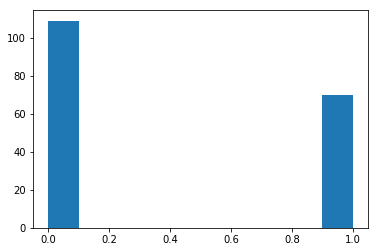

In [60]:
plt.hist(final_predictions)

In [61]:
from sklearn.metrics import confusion_matrix

cm_val = confusion_matrix(y_val, final_predictions).astype(np.float32)
cm_val /= cm_val.sum(axis=1)[:, np.newaxis]

Text(0.5,1,'Val')

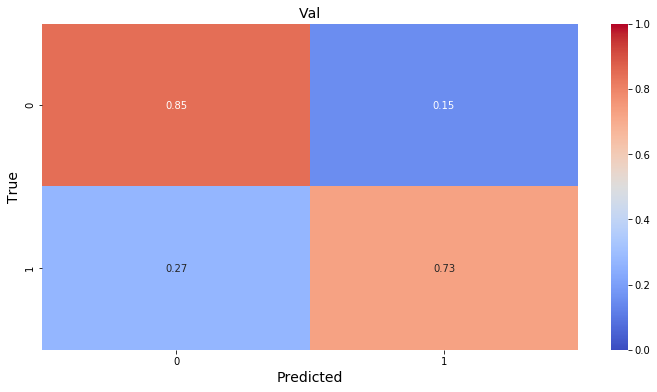

In [62]:
plt.figure(figsize=(12, 6))

plt.subplot(111)
g = sns.heatmap(cm_val, vmin=0, vmax=1, annot=True, cmap="coolwarm")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=[0,1], yticklabels=[0,1])
plt.title("Val", fontsize=14)

## Reading Test Data

In [63]:
test = pd.read_csv('datasets/titanic/test.csv')
test = test.drop(['Ticket', 'Cabin'], axis = 1)

In [64]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S


In [65]:
test.shape

(418, 9)

## Full Pipeline with Predictor on Test Data

In [66]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),  # combination of numerical and categorical pipelines
        ("logRegression", final_model) # LogisticRegression(C: 1.0, max_iter: 100, penalty: 'l1')
    ])

In [67]:
full_pipeline_with_predictor.named_steps.preparation.transformer_list

[('num_pipeline', Pipeline(memory=None,
       steps=[('selector', DataFrameSelector(attribute_names=['Age', 'Parch', 'SibSp'])), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('std_scaler', MinMaxScaler(copy=True, feature_range=(0, 1)))])),
 ('cat_pipeline', Pipeline(memory=None,
       steps=[('selector', DataFrameSelector(attribute_names=['Embarked', 'Sex'])), ('cat_encoder', CategoricalEncoder(categories='auto', dtype=<class 'numpy.float64'>,
            encoding='onehot-dense', handle_unknown='error'))])),
 ('Custcat_pipeline', Pipeline(memory=None,
       steps=[('selector', DataFrameSelector1(attribute_names=['Name'])), ('attribs_adder', CombinedAttributesAdder()), ('cat_encoder', CategoricalEncoder(categories='auto', dtype=<class 'numpy.float64'>,
            encoding='onehot-dense', handle_unknown='error'))]))]

In [68]:
x_val_predicted = full_pipeline_with_predictor.predict(x_val)

In [69]:
test_predicted = full_pipeline_with_predictor.predict(test)

(array([262.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 156.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

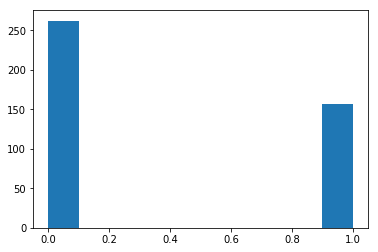

In [70]:
plt.hist(test_predicted)